In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
DATA = Path('../../Data')

In [3]:
%time train_df = pd.read_csv(DATA/'train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 2min 23s


In [4]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [5]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [6]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


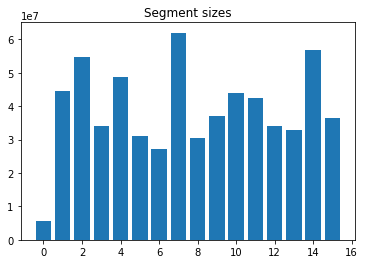

In [7]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [8]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        # Homogeneous
#         segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
#         segment = self.segments[segment_index]
#         end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)
        # Heterogeneous
        end_indexes = np.random.randint(self.segments[0][0] + self.ts_length + 25000,
                                        self.segments[-1][1], size=self.batch_size)
        # Heterogeneous, Low-Res
        end_indexes = (end_indexes // 25000) * 25000

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [9]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [10]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [11]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [12]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [13]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [14]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
   # x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    
    y = Dense(1)(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

In [15]:
model = CnnTransformerModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15000, 8)     88          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1500, 16)     1296        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

Train the model with early stopping

In [16]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 12, # 150
    verbose = 1, 
    validation_data = valid_gen,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience = 150, verbose = 0)
    ]
)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/12


318/400 [======================>.......] - ETA: 48:16 - loss: 6.04 - ETA: 25:28 - loss: 4.65 - ETA: 17:54 - loss: 4.34 - ETA: 14:06 - loss: 4.06 - ETA: 11:49 - loss: 3.95 - ETA: 10:18 - loss: 3.78 - ETA: 9:12 - loss: 3.6652 - ETA: 8:23 - loss: 3.577 - ETA: 7:44 - loss: 3.501 - ETA: 7:14 - loss: 3.412 - ETA: 6:49 - loss: 3.339 - ETA: 6:27 - loss: 3.269 - ETA: 6:10 - loss: 3.232 - ETA: 5:54 - loss: 3.170 - ETA: 5:41 - loss: 3.141 - ETA: 5:29 - loss: 3.136 - ETA: 5:19 - loss: 3.114 - ETA: 5:09 - loss: 3.097 - ETA: 5:01 - loss: 3.050 - ETA: 4:53 - loss: 3.062 - ETA: 4:46 - loss: 3.067 - ETA: 4:40 - loss: 3.057 - ETA: 4:34 - loss: 3.067 - ETA: 4:29 - loss: 3.067 - ETA: 4:24 - loss: 3.043 - ETA: 4:19 - loss: 3.018 - ETA: 4:15 - loss: 3.004 - ETA: 4:11 - loss: 3.002 - ETA: 4:07 - loss: 2.987 - ETA: 4:03 - loss: 2.973 - ETA: 4:00 - loss: 2.961 - ETA: 3:57 - loss: 2.948 - ETA: 3:54 - loss: 2.936 - ETA: 3:51 - loss: 2.928 - ETA: 3:48 - loss: 2.916 - ETA: 3:46 - loss: 2.892 - ETA: 3:43 - loss: 2.

400/400 [==============================] - ETA: 36s - loss: 2.32 - ETA: 36s - loss: 2.31 - ETA: 35s - loss: 2.31 - ETA: 35s - loss: 2.32 - ETA: 34s - loss: 2.31 - ETA: 34s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 32s - loss: 2.31 - ETA: 32s - loss: 2.31 - ETA: 31s - loss: 2.31 - ETA: 31s - loss: 2.31 - ETA: 30s - loss: 2.31 - ETA: 30s - loss: 2.31 - ETA: 29s - loss: 2.31 - ETA: 29s - loss: 2.31 - ETA: 28s - loss: 2.31 - ETA: 28s - loss: 2.31 - ETA: 28s - loss: 2.31 - ETA: 27s - loss: 2.30 - ETA: 27s - loss: 2.31 - ETA: 26s - loss: 2.31 - ETA: 26s - loss: 2.31 - ETA: 25s - loss: 2.31 - ETA: 25s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 23s - loss: 2.31 - ETA: 23s - loss: 2.31 - ETA: 23s - loss: 2.31 - ETA: 22s - loss: 2.31 - ETA: 22s - loss: 2.31 - ETA: 21s - loss: 2.31 - ETA: 21s - loss: 2.31 - ETA: 20s - loss: 2.31 - ETA: 20s - loss: 2.31 - ETA: 19s - loss: 2.31 - ETA: 19s - loss: 2.31 - ETA: 18s - loss: 2.31

318/400 [======================>.......] - ETA: 3:01 - loss: 1.880 - ETA: 3:01 - loss: 2.001 - ETA: 2:59 - loss: 1.999 - ETA: 2:57 - loss: 2.162 - ETA: 2:58 - loss: 2.115 - ETA: 2:57 - loss: 2.120 - ETA: 2:56 - loss: 2.139 - ETA: 2:55 - loss: 2.175 - ETA: 2:53 - loss: 2.187 - ETA: 2:53 - loss: 2.172 - ETA: 2:52 - loss: 2.158 - ETA: 2:51 - loss: 2.133 - ETA: 2:50 - loss: 2.125 - ETA: 2:49 - loss: 2.136 - ETA: 2:49 - loss: 2.178 - ETA: 2:48 - loss: 2.180 - ETA: 2:47 - loss: 2.181 - ETA: 2:47 - loss: 2.182 - ETA: 2:46 - loss: 2.187 - ETA: 2:46 - loss: 2.218 - ETA: 2:45 - loss: 2.216 - ETA: 2:45 - loss: 2.230 - ETA: 2:44 - loss: 2.217 - ETA: 2:44 - loss: 2.227 - ETA: 2:43 - loss: 2.229 - ETA: 2:43 - loss: 2.243 - ETA: 2:42 - loss: 2.234 - ETA: 2:41 - loss: 2.223 - ETA: 2:41 - loss: 2.224 - ETA: 2:40 - loss: 2.226 - ETA: 2:40 - loss: 2.231 - ETA: 2:40 - loss: 2.240 - ETA: 2:39 - loss: 2.230 - ETA: 2:39 - loss: 2.228 - ETA: 2:38 - loss: 2.224 - ETA: 2:38 - loss: 2.225 - ETA: 2:37 - loss: 2.2

400/400 [==============================] - ETA: 34s - loss: 2.15 - ETA: 34s - loss: 2.15 - ETA: 34s - loss: 2.15 - ETA: 33s - loss: 2.15 - ETA: 33s - loss: 2.15 - ETA: 32s - loss: 2.16 - ETA: 32s - loss: 2.16 - ETA: 31s - loss: 2.15 - ETA: 31s - loss: 2.15 - ETA: 31s - loss: 2.15 - ETA: 30s - loss: 2.15 - ETA: 30s - loss: 2.15 - ETA: 29s - loss: 2.15 - ETA: 29s - loss: 2.15 - ETA: 28s - loss: 2.15 - ETA: 28s - loss: 2.15 - ETA: 28s - loss: 2.15 - ETA: 27s - loss: 2.15 - ETA: 27s - loss: 2.15 - ETA: 26s - loss: 2.15 - ETA: 26s - loss: 2.15 - ETA: 25s - loss: 2.15 - ETA: 25s - loss: 2.15 - ETA: 25s - loss: 2.14 - ETA: 24s - loss: 2.14 - ETA: 24s - loss: 2.14 - ETA: 23s - loss: 2.14 - ETA: 23s - loss: 2.14 - ETA: 22s - loss: 2.14 - ETA: 22s - loss: 2.14 - ETA: 22s - loss: 2.14 - ETA: 21s - loss: 2.14 - ETA: 21s - loss: 2.14 - ETA: 20s - loss: 2.14 - ETA: 20s - loss: 2.14 - ETA: 19s - loss: 2.14 - ETA: 19s - loss: 2.14 - ETA: 19s - loss: 2.14 - ETA: 18s - loss: 2.14 - ETA: 18s - loss: 2.14

318/400 [======================>.......] - ETA: 3:05 - loss: 1.866 - ETA: 3:04 - loss: 1.977 - ETA: 3:01 - loss: 1.970 - ETA: 2:57 - loss: 1.950 - ETA: 2:56 - loss: 1.895 - ETA: 2:54 - loss: 1.916 - ETA: 2:54 - loss: 1.943 - ETA: 2:53 - loss: 1.981 - ETA: 2:53 - loss: 1.972 - ETA: 2:52 - loss: 2.031 - ETA: 2:51 - loss: 2.038 - ETA: 2:50 - loss: 2.052 - ETA: 2:49 - loss: 2.052 - ETA: 2:49 - loss: 2.023 - ETA: 2:48 - loss: 2.045 - ETA: 2:48 - loss: 2.031 - ETA: 2:47 - loss: 2.049 - ETA: 2:46 - loss: 2.045 - ETA: 2:46 - loss: 2.040 - ETA: 2:45 - loss: 2.037 - ETA: 2:44 - loss: 2.030 - ETA: 2:44 - loss: 2.033 - ETA: 2:44 - loss: 2.033 - ETA: 2:43 - loss: 2.026 - ETA: 2:43 - loss: 2.031 - ETA: 2:42 - loss: 2.042 - ETA: 2:41 - loss: 2.051 - ETA: 2:41 - loss: 2.054 - ETA: 2:40 - loss: 2.054 - ETA: 2:40 - loss: 2.058 - ETA: 2:40 - loss: 2.056 - ETA: 2:39 - loss: 2.054 - ETA: 2:39 - loss: 2.059 - ETA: 2:38 - loss: 2.055 - ETA: 2:38 - loss: 2.060 - ETA: 2:37 - loss: 2.055 - ETA: 2:37 - loss: 2.0

400/400 [==============================] - ETA: 34s - loss: 2.02 - ETA: 34s - loss: 2.02 - ETA: 34s - loss: 2.02 - ETA: 33s - loss: 2.02 - ETA: 33s - loss: 2.01 - ETA: 32s - loss: 2.01 - ETA: 32s - loss: 2.02 - ETA: 31s - loss: 2.02 - ETA: 31s - loss: 2.01 - ETA: 31s - loss: 2.01 - ETA: 30s - loss: 2.01 - ETA: 30s - loss: 2.01 - ETA: 29s - loss: 2.01 - ETA: 29s - loss: 2.01 - ETA: 28s - loss: 2.01 - ETA: 28s - loss: 2.01 - ETA: 28s - loss: 2.01 - ETA: 27s - loss: 2.01 - ETA: 27s - loss: 2.01 - ETA: 26s - loss: 2.01 - ETA: 26s - loss: 2.01 - ETA: 25s - loss: 2.01 - ETA: 25s - loss: 2.01 - ETA: 25s - loss: 2.01 - ETA: 24s - loss: 2.01 - ETA: 24s - loss: 2.01 - ETA: 23s - loss: 2.01 - ETA: 23s - loss: 2.01 - ETA: 22s - loss: 2.01 - ETA: 22s - loss: 2.01 - ETA: 21s - loss: 2.01 - ETA: 21s - loss: 2.01 - ETA: 21s - loss: 2.01 - ETA: 20s - loss: 2.01 - ETA: 20s - loss: 2.01 - ETA: 19s - loss: 2.01 - ETA: 19s - loss: 2.01 - ETA: 18s - loss: 2.01 - ETA: 18s - loss: 2.01 - ETA: 18s - loss: 2.01

318/400 [======================>.......] - ETA: 2:51 - loss: 2.235 - ETA: 2:56 - loss: 1.935 - ETA: 2:56 - loss: 1.956 - ETA: 2:53 - loss: 1.965 - ETA: 2:52 - loss: 1.937 - ETA: 2:51 - loss: 1.895 - ETA: 2:51 - loss: 1.896 - ETA: 2:50 - loss: 1.884 - ETA: 2:49 - loss: 1.859 - ETA: 2:49 - loss: 1.860 - ETA: 2:48 - loss: 1.847 - ETA: 2:48 - loss: 1.844 - ETA: 2:47 - loss: 1.877 - ETA: 2:46 - loss: 1.867 - ETA: 2:46 - loss: 1.893 - ETA: 2:45 - loss: 1.920 - ETA: 2:45 - loss: 1.915 - ETA: 2:45 - loss: 1.899 - ETA: 2:44 - loss: 1.891 - ETA: 2:44 - loss: 1.895 - ETA: 2:43 - loss: 1.909 - ETA: 2:43 - loss: 1.901 - ETA: 2:43 - loss: 1.895 - ETA: 2:42 - loss: 1.896 - ETA: 2:42 - loss: 1.919 - ETA: 2:41 - loss: 1.898 - ETA: 2:41 - loss: 1.896 - ETA: 2:40 - loss: 1.894 - ETA: 2:40 - loss: 1.882 - ETA: 2:39 - loss: 1.891 - ETA: 2:39 - loss: 1.902 - ETA: 2:39 - loss: 1.907 - ETA: 2:38 - loss: 1.895 - ETA: 2:38 - loss: 1.895 - ETA: 2:37 - loss: 1.898 - ETA: 2:37 - loss: 1.887 - ETA: 2:36 - loss: 1.8

400/400 [==============================] - ETA: 34s - loss: 1.89 - ETA: 34s - loss: 1.89 - ETA: 34s - loss: 1.89 - ETA: 33s - loss: 1.89 - ETA: 33s - loss: 1.89 - ETA: 32s - loss: 1.89 - ETA: 32s - loss: 1.89 - ETA: 31s - loss: 1.89 - ETA: 31s - loss: 1.89 - ETA: 31s - loss: 1.89 - ETA: 30s - loss: 1.89 - ETA: 30s - loss: 1.89 - ETA: 29s - loss: 1.89 - ETA: 29s - loss: 1.89 - ETA: 28s - loss: 1.89 - ETA: 28s - loss: 1.89 - ETA: 28s - loss: 1.89 - ETA: 27s - loss: 1.89 - ETA: 27s - loss: 1.89 - ETA: 26s - loss: 1.89 - ETA: 26s - loss: 1.88 - ETA: 25s - loss: 1.89 - ETA: 25s - loss: 1.88 - ETA: 24s - loss: 1.88 - ETA: 24s - loss: 1.88 - ETA: 24s - loss: 1.88 - ETA: 23s - loss: 1.88 - ETA: 23s - loss: 1.88 - ETA: 22s - loss: 1.88 - ETA: 22s - loss: 1.88 - ETA: 21s - loss: 1.88 - ETA: 21s - loss: 1.88 - ETA: 21s - loss: 1.88 - ETA: 20s - loss: 1.88 - ETA: 20s - loss: 1.88 - ETA: 19s - loss: 1.88 - ETA: 19s - loss: 1.88 - ETA: 18s - loss: 1.88 - ETA: 18s - loss: 1.88 - ETA: 18s - loss: 1.88

318/400 [======================>.......] - ETA: 2:58 - loss: 2.111 - ETA: 2:55 - loss: 1.913 - ETA: 2:54 - loss: 1.890 - ETA: 2:53 - loss: 1.820 - ETA: 2:52 - loss: 1.831 - ETA: 2:51 - loss: 1.857 - ETA: 2:51 - loss: 1.826 - ETA: 2:50 - loss: 1.797 - ETA: 2:50 - loss: 1.777 - ETA: 2:49 - loss: 1.791 - ETA: 2:48 - loss: 1.785 - ETA: 2:48 - loss: 1.759 - ETA: 2:47 - loss: 1.742 - ETA: 2:47 - loss: 1.747 - ETA: 2:46 - loss: 1.743 - ETA: 2:45 - loss: 1.738 - ETA: 2:45 - loss: 1.745 - ETA: 2:45 - loss: 1.753 - ETA: 2:44 - loss: 1.751 - ETA: 2:44 - loss: 1.760 - ETA: 2:43 - loss: 1.759 - ETA: 2:43 - loss: 1.752 - ETA: 2:42 - loss: 1.744 - ETA: 2:42 - loss: 1.741 - ETA: 2:41 - loss: 1.740 - ETA: 2:41 - loss: 1.746 - ETA: 2:40 - loss: 1.744 - ETA: 2:40 - loss: 1.751 - ETA: 2:40 - loss: 1.754 - ETA: 2:39 - loss: 1.757 - ETA: 2:39 - loss: 1.767 - ETA: 2:39 - loss: 1.770 - ETA: 2:38 - loss: 1.773 - ETA: 2:38 - loss: 1.774 - ETA: 2:37 - loss: 1.770 - ETA: 2:37 - loss: 1.779 - ETA: 2:36 - loss: 1.7

400/400 [==============================] - ETA: 34s - loss: 1.73 - ETA: 34s - loss: 1.73 - ETA: 33s - loss: 1.73 - ETA: 33s - loss: 1.73 - ETA: 33s - loss: 1.73 - ETA: 32s - loss: 1.73 - ETA: 32s - loss: 1.73 - ETA: 31s - loss: 1.73 - ETA: 31s - loss: 1.73 - ETA: 30s - loss: 1.73 - ETA: 30s - loss: 1.73 - ETA: 30s - loss: 1.73 - ETA: 29s - loss: 1.73 - ETA: 29s - loss: 1.73 - ETA: 28s - loss: 1.73 - ETA: 28s - loss: 1.73 - ETA: 27s - loss: 1.73 - ETA: 27s - loss: 1.73 - ETA: 27s - loss: 1.73 - ETA: 26s - loss: 1.73 - ETA: 26s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 23s - loss: 1.73 - ETA: 23s - loss: 1.73 - ETA: 22s - loss: 1.73 - ETA: 22s - loss: 1.73 - ETA: 21s - loss: 1.73 - ETA: 21s - loss: 1.73 - ETA: 21s - loss: 1.73 - ETA: 20s - loss: 1.73 - ETA: 20s - loss: 1.73 - ETA: 19s - loss: 1.73 - ETA: 19s - loss: 1.73 - ETA: 18s - loss: 1.73 - ETA: 18s - loss: 1.73 - ETA: 18s - loss: 1.73

318/400 [======================>.......] - ETA: 2:57 - loss: 1.275 - ETA: 2:59 - loss: 1.484 - ETA: 2:58 - loss: 1.579 - ETA: 2:56 - loss: 1.624 - ETA: 2:55 - loss: 1.602 - ETA: 2:54 - loss: 1.657 - ETA: 2:53 - loss: 1.649 - ETA: 2:52 - loss: 1.643 - ETA: 2:51 - loss: 1.641 - ETA: 2:50 - loss: 1.667 - ETA: 2:49 - loss: 1.651 - ETA: 2:49 - loss: 1.666 - ETA: 2:48 - loss: 1.682 - ETA: 2:47 - loss: 1.698 - ETA: 2:47 - loss: 1.702 - ETA: 2:46 - loss: 1.707 - ETA: 2:46 - loss: 1.740 - ETA: 2:45 - loss: 1.734 - ETA: 2:45 - loss: 1.731 - ETA: 2:45 - loss: 1.718 - ETA: 2:44 - loss: 1.715 - ETA: 2:43 - loss: 1.720 - ETA: 2:43 - loss: 1.704 - ETA: 2:43 - loss: 1.697 - ETA: 2:42 - loss: 1.696 - ETA: 2:42 - loss: 1.694 - ETA: 2:41 - loss: 1.696 - ETA: 2:41 - loss: 1.697 - ETA: 2:40 - loss: 1.706 - ETA: 2:40 - loss: 1.698 - ETA: 2:39 - loss: 1.704 - ETA: 2:39 - loss: 1.707 - ETA: 2:38 - loss: 1.705 - ETA: 2:38 - loss: 1.703 - ETA: 2:37 - loss: 1.702 - ETA: 2:37 - loss: 1.707 - ETA: 2:36 - loss: 1.7

400/400 [==============================] - ETA: 34s - loss: 1.63 - ETA: 34s - loss: 1.63 - ETA: 34s - loss: 1.63 - ETA: 33s - loss: 1.63 - ETA: 33s - loss: 1.63 - ETA: 32s - loss: 1.63 - ETA: 32s - loss: 1.63 - ETA: 31s - loss: 1.63 - ETA: 31s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 29s - loss: 1.63 - ETA: 29s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 25s - loss: 1.63 - ETA: 25s - loss: 1.63 - ETA: 24s - loss: 1.63 - ETA: 24s - loss: 1.63 - ETA: 24s - loss: 1.63 - ETA: 23s - loss: 1.63 - ETA: 23s - loss: 1.63 - ETA: 22s - loss: 1.63 - ETA: 22s - loss: 1.63 - ETA: 21s - loss: 1.63 - ETA: 21s - loss: 1.63 - ETA: 21s - loss: 1.63 - ETA: 20s - loss: 1.63 - ETA: 20s - loss: 1.63 - ETA: 19s - loss: 1.63 - ETA: 19s - loss: 1.63 - ETA: 18s - loss: 1.63 - ETA: 18s - loss: 1.63 - ETA: 18s - loss: 1.63

318/400 [======================>.......] - ETA: 2:57 - loss: 1.389 - ETA: 2:56 - loss: 1.314 - ETA: 2:56 - loss: 1.415 - ETA: 2:55 - loss: 1.499 - ETA: 2:55 - loss: 1.493 - ETA: 2:54 - loss: 1.533 - ETA: 2:54 - loss: 1.489 - ETA: 2:53 - loss: 1.490 - ETA: 2:51 - loss: 1.450 - ETA: 2:51 - loss: 1.479 - ETA: 2:50 - loss: 1.484 - ETA: 2:50 - loss: 1.478 - ETA: 2:48 - loss: 1.478 - ETA: 2:48 - loss: 1.480 - ETA: 2:47 - loss: 1.478 - ETA: 2:47 - loss: 1.502 - ETA: 2:46 - loss: 1.499 - ETA: 2:45 - loss: 1.489 - ETA: 2:45 - loss: 1.500 - ETA: 2:44 - loss: 1.509 - ETA: 2:44 - loss: 1.505 - ETA: 2:43 - loss: 1.504 - ETA: 2:43 - loss: 1.501 - ETA: 2:42 - loss: 1.518 - ETA: 2:42 - loss: 1.502 - ETA: 2:42 - loss: 1.503 - ETA: 2:41 - loss: 1.504 - ETA: 2:41 - loss: 1.504 - ETA: 2:40 - loss: 1.513 - ETA: 2:40 - loss: 1.501 - ETA: 2:39 - loss: 1.498 - ETA: 2:39 - loss: 1.491 - ETA: 2:38 - loss: 1.488 - ETA: 2:38 - loss: 1.483 - ETA: 2:37 - loss: 1.486 - ETA: 2:37 - loss: 1.485 - ETA: 2:36 - loss: 1.4

400/400 [==============================] - ETA: 34s - loss: 1.51 - ETA: 34s - loss: 1.51 - ETA: 34s - loss: 1.51 - ETA: 33s - loss: 1.51 - ETA: 33s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 28s - loss: 1.51 - ETA: 28s - loss: 1.51 - ETA: 27s - loss: 1.51 - ETA: 27s - loss: 1.51 - ETA: 27s - loss: 1.51 - ETA: 26s - loss: 1.51 - ETA: 26s - loss: 1.51 - ETA: 25s - loss: 1.51 - ETA: 25s - loss: 1.52 - ETA: 24s - loss: 1.51 - ETA: 24s - loss: 1.51 - ETA: 24s - loss: 1.51 - ETA: 23s - loss: 1.51 - ETA: 23s - loss: 1.51 - ETA: 22s - loss: 1.51 - ETA: 22s - loss: 1.51 - ETA: 21s - loss: 1.51 - ETA: 21s - loss: 1.51 - ETA: 21s - loss: 1.51 - ETA: 20s - loss: 1.51 - ETA: 20s - loss: 1.51 - ETA: 19s - loss: 1.51 - ETA: 19s - loss: 1.52 - ETA: 18s - loss: 1.51 - ETA: 18s - loss: 1.52 - ETA: 18s - loss: 1.51

318/400 [======================>.......] - ETA: 2:59 - loss: 1.366 - ETA: 2:58 - loss: 1.414 - ETA: 2:57 - loss: 1.369 - ETA: 2:55 - loss: 1.379 - ETA: 2:54 - loss: 1.382 - ETA: 2:54 - loss: 1.401 - ETA: 2:52 - loss: 1.387 - ETA: 2:51 - loss: 1.431 - ETA: 2:50 - loss: 1.438 - ETA: 2:50 - loss: 1.405 - ETA: 2:49 - loss: 1.423 - ETA: 2:49 - loss: 1.423 - ETA: 2:48 - loss: 1.459 - ETA: 2:47 - loss: 1.459 - ETA: 2:46 - loss: 1.442 - ETA: 2:46 - loss: 1.431 - ETA: 2:46 - loss: 1.426 - ETA: 2:45 - loss: 1.426 - ETA: 2:45 - loss: 1.426 - ETA: 2:45 - loss: 1.445 - ETA: 2:44 - loss: 1.444 - ETA: 2:44 - loss: 1.444 - ETA: 2:43 - loss: 1.471 - ETA: 2:43 - loss: 1.465 - ETA: 2:42 - loss: 1.459 - ETA: 2:42 - loss: 1.452 - ETA: 2:41 - loss: 1.462 - ETA: 2:41 - loss: 1.466 - ETA: 2:40 - loss: 1.473 - ETA: 2:40 - loss: 1.472 - ETA: 2:39 - loss: 1.453 - ETA: 2:39 - loss: 1.448 - ETA: 2:38 - loss: 1.459 - ETA: 2:38 - loss: 1.461 - ETA: 2:37 - loss: 1.456 - ETA: 2:37 - loss: 1.453 - ETA: 2:36 - loss: 1.4

400/400 [==============================] - ETA: 34s - loss: 1.51 - ETA: 34s - loss: 1.51 - ETA: 33s - loss: 1.51 - ETA: 33s - loss: 1.50 - ETA: 33s - loss: 1.50 - ETA: 32s - loss: 1.50 - ETA: 32s - loss: 1.50 - ETA: 31s - loss: 1.50 - ETA: 31s - loss: 1.50 - ETA: 30s - loss: 1.50 - ETA: 30s - loss: 1.50 - ETA: 30s - loss: 1.50 - ETA: 29s - loss: 1.50 - ETA: 29s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 24s - loss: 1.50 - ETA: 24s - loss: 1.50 - ETA: 24s - loss: 1.50 - ETA: 23s - loss: 1.50 - ETA: 23s - loss: 1.50 - ETA: 22s - loss: 1.50 - ETA: 22s - loss: 1.50 - ETA: 21s - loss: 1.50 - ETA: 21s - loss: 1.50 - ETA: 21s - loss: 1.50 - ETA: 20s - loss: 1.50 - ETA: 20s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50

318/400 [======================>.......] - ETA: 2:57 - loss: 1.405 - ETA: 2:56 - loss: 1.484 - ETA: 2:55 - loss: 1.543 - ETA: 2:53 - loss: 1.594 - ETA: 2:53 - loss: 1.505 - ETA: 2:52 - loss: 1.530 - ETA: 2:51 - loss: 1.535 - ETA: 2:50 - loss: 1.539 - ETA: 2:50 - loss: 1.535 - ETA: 2:49 - loss: 1.536 - ETA: 2:48 - loss: 1.507 - ETA: 2:47 - loss: 1.499 - ETA: 2:46 - loss: 1.468 - ETA: 2:47 - loss: 1.481 - ETA: 2:46 - loss: 1.495 - ETA: 2:45 - loss: 1.497 - ETA: 2:45 - loss: 1.483 - ETA: 2:45 - loss: 1.481 - ETA: 2:44 - loss: 1.477 - ETA: 2:44 - loss: 1.488 - ETA: 2:43 - loss: 1.474 - ETA: 2:43 - loss: 1.475 - ETA: 2:42 - loss: 1.472 - ETA: 2:42 - loss: 1.458 - ETA: 2:41 - loss: 1.451 - ETA: 2:41 - loss: 1.448 - ETA: 2:40 - loss: 1.443 - ETA: 2:40 - loss: 1.438 - ETA: 2:39 - loss: 1.435 - ETA: 2:39 - loss: 1.437 - ETA: 2:38 - loss: 1.441 - ETA: 2:38 - loss: 1.450 - ETA: 2:38 - loss: 1.449 - ETA: 2:37 - loss: 1.450 - ETA: 2:37 - loss: 1.443 - ETA: 2:36 - loss: 1.437 - ETA: 2:36 - loss: 1.4

400/400 [==============================] - ETA: 34s - loss: 1.39 - ETA: 34s - loss: 1.39 - ETA: 33s - loss: 1.39 - ETA: 33s - loss: 1.39 - ETA: 33s - loss: 1.39 - ETA: 32s - loss: 1.39 - ETA: 32s - loss: 1.39 - ETA: 31s - loss: 1.39 - ETA: 31s - loss: 1.39 - ETA: 30s - loss: 1.39 - ETA: 30s - loss: 1.39 - ETA: 30s - loss: 1.39 - ETA: 29s - loss: 1.39 - ETA: 29s - loss: 1.39 - ETA: 28s - loss: 1.39 - ETA: 28s - loss: 1.39 - ETA: 27s - loss: 1.39 - ETA: 27s - loss: 1.40 - ETA: 27s - loss: 1.39 - ETA: 26s - loss: 1.39 - ETA: 26s - loss: 1.40 - ETA: 25s - loss: 1.40 - ETA: 25s - loss: 1.40 - ETA: 24s - loss: 1.40 - ETA: 24s - loss: 1.40 - ETA: 24s - loss: 1.40 - ETA: 23s - loss: 1.40 - ETA: 23s - loss: 1.40 - ETA: 22s - loss: 1.40 - ETA: 22s - loss: 1.40 - ETA: 21s - loss: 1.40 - ETA: 21s - loss: 1.40 - ETA: 21s - loss: 1.40 - ETA: 20s - loss: 1.40 - ETA: 20s - loss: 1.40 - ETA: 19s - loss: 1.40 - ETA: 19s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39

318/400 [======================>.......] - ETA: 2:57 - loss: 1.320 - ETA: 2:56 - loss: 1.383 - ETA: 2:59 - loss: 1.335 - ETA: 2:58 - loss: 1.334 - ETA: 2:55 - loss: 1.365 - ETA: 2:53 - loss: 1.330 - ETA: 2:53 - loss: 1.350 - ETA: 2:52 - loss: 1.330 - ETA: 2:51 - loss: 1.332 - ETA: 2:50 - loss: 1.311 - ETA: 2:49 - loss: 1.321 - ETA: 2:49 - loss: 1.350 - ETA: 2:48 - loss: 1.356 - ETA: 2:47 - loss: 1.370 - ETA: 2:47 - loss: 1.371 - ETA: 2:46 - loss: 1.363 - ETA: 2:46 - loss: 1.350 - ETA: 2:45 - loss: 1.348 - ETA: 2:45 - loss: 1.359 - ETA: 2:44 - loss: 1.366 - ETA: 2:44 - loss: 1.365 - ETA: 2:43 - loss: 1.356 - ETA: 2:42 - loss: 1.355 - ETA: 2:42 - loss: 1.351 - ETA: 2:42 - loss: 1.340 - ETA: 2:41 - loss: 1.337 - ETA: 2:41 - loss: 1.335 - ETA: 2:40 - loss: 1.333 - ETA: 2:40 - loss: 1.333 - ETA: 2:39 - loss: 1.331 - ETA: 2:39 - loss: 1.334 - ETA: 2:38 - loss: 1.334 - ETA: 2:38 - loss: 1.334 - ETA: 2:37 - loss: 1.333 - ETA: 2:37 - loss: 1.334 - ETA: 2:36 - loss: 1.327 - ETA: 2:36 - loss: 1.3

400/400 [==============================] - ETA: 34s - loss: 1.32 - ETA: 34s - loss: 1.32 - ETA: 34s - loss: 1.32 - ETA: 33s - loss: 1.32 - ETA: 33s - loss: 1.32 - ETA: 32s - loss: 1.32 - ETA: 32s - loss: 1.32 - ETA: 31s - loss: 1.32 - ETA: 31s - loss: 1.32 - ETA: 30s - loss: 1.32 - ETA: 30s - loss: 1.32 - ETA: 30s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 25s - loss: 1.32 - ETA: 25s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 20s - loss: 1.32 - ETA: 20s - loss: 1.32 - ETA: 19s - loss: 1.32 - ETA: 19s - loss: 1.32 - ETA: 18s - loss: 1.32 - ETA: 18s - loss: 1.32 - ETA: 18s - loss: 1.32

318/400 [======================>.......] - ETA: 2:57 - loss: 1.289 - ETA: 2:55 - loss: 1.151 - ETA: 2:56 - loss: 1.170 - ETA: 2:56 - loss: 1.290 - ETA: 2:53 - loss: 1.288 - ETA: 2:52 - loss: 1.287 - ETA: 2:52 - loss: 1.284 - ETA: 2:50 - loss: 1.325 - ETA: 2:50 - loss: 1.348 - ETA: 2:49 - loss: 1.316 - ETA: 2:48 - loss: 1.305 - ETA: 2:48 - loss: 1.303 - ETA: 2:47 - loss: 1.318 - ETA: 2:47 - loss: 1.305 - ETA: 2:46 - loss: 1.280 - ETA: 2:46 - loss: 1.274 - ETA: 2:45 - loss: 1.270 - ETA: 2:45 - loss: 1.264 - ETA: 2:44 - loss: 1.270 - ETA: 2:44 - loss: 1.271 - ETA: 2:43 - loss: 1.265 - ETA: 2:43 - loss: 1.260 - ETA: 2:42 - loss: 1.261 - ETA: 2:42 - loss: 1.277 - ETA: 2:41 - loss: 1.276 - ETA: 2:41 - loss: 1.278 - ETA: 2:40 - loss: 1.281 - ETA: 2:40 - loss: 1.277 - ETA: 2:40 - loss: 1.280 - ETA: 2:39 - loss: 1.282 - ETA: 2:39 - loss: 1.290 - ETA: 2:38 - loss: 1.297 - ETA: 2:38 - loss: 1.296 - ETA: 2:37 - loss: 1.310 - ETA: 2:37 - loss: 1.325 - ETA: 2:36 - loss: 1.323 - ETA: 2:36 - loss: 1.3

400/400 [==============================] - ETA: 34s - loss: 1.31 - ETA: 34s - loss: 1.31 - ETA: 34s - loss: 1.31 - ETA: 33s - loss: 1.31 - ETA: 33s - loss: 1.31 - ETA: 32s - loss: 1.31 - ETA: 32s - loss: 1.31 - ETA: 31s - loss: 1.31 - ETA: 31s - loss: 1.31 - ETA: 31s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.30 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.30 - ETA: 28s - loss: 1.30 - ETA: 28s - loss: 1.30 - ETA: 27s - loss: 1.30 - ETA: 27s - loss: 1.30 - ETA: 27s - loss: 1.30 - ETA: 26s - loss: 1.30 - ETA: 26s - loss: 1.30 - ETA: 25s - loss: 1.30 - ETA: 25s - loss: 1.30 - ETA: 24s - loss: 1.30 - ETA: 24s - loss: 1.30 - ETA: 24s - loss: 1.30 - ETA: 23s - loss: 1.30 - ETA: 23s - loss: 1.30 - ETA: 22s - loss: 1.30 - ETA: 22s - loss: 1.30 - ETA: 21s - loss: 1.30 - ETA: 21s - loss: 1.30 - ETA: 21s - loss: 1.30 - ETA: 20s - loss: 1.30 - ETA: 20s - loss: 1.30 - ETA: 19s - loss: 1.31 - ETA: 19s - loss: 1.30 - ETA: 18s - loss: 1.31 - ETA: 18s - loss: 1.31 - ETA: 18s - loss: 1.31

318/400 [======================>.......] - ETA: 2:56 - loss: 1.584 - ETA: 2:53 - loss: 1.380 - ETA: 2:54 - loss: 1.366 - ETA: 2:54 - loss: 1.357 - ETA: 2:53 - loss: 1.365 - ETA: 2:52 - loss: 1.338 - ETA: 2:51 - loss: 1.322 - ETA: 2:50 - loss: 1.328 - ETA: 2:50 - loss: 1.313 - ETA: 2:49 - loss: 1.304 - ETA: 2:49 - loss: 1.307 - ETA: 2:48 - loss: 1.310 - ETA: 2:48 - loss: 1.292 - ETA: 2:47 - loss: 1.277 - ETA: 2:47 - loss: 1.290 - ETA: 2:46 - loss: 1.290 - ETA: 2:45 - loss: 1.289 - ETA: 2:45 - loss: 1.290 - ETA: 2:44 - loss: 1.303 - ETA: 2:44 - loss: 1.303 - ETA: 2:44 - loss: 1.306 - ETA: 2:43 - loss: 1.303 - ETA: 2:43 - loss: 1.297 - ETA: 2:42 - loss: 1.298 - ETA: 2:42 - loss: 1.287 - ETA: 2:41 - loss: 1.285 - ETA: 2:41 - loss: 1.294 - ETA: 2:40 - loss: 1.291 - ETA: 2:40 - loss: 1.297 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.304 - ETA: 2:38 - loss: 1.310 - ETA: 2:38 - loss: 1.307 - ETA: 2:37 - loss: 1.312 - ETA: 2:37 - loss: 1.310 - ETA: 2:37 - loss: 1.309 - ETA: 2:36 - loss: 1.3

400/400 [==============================] - ETA: 34s - loss: 1.25 - ETA: 34s - loss: 1.24 - ETA: 34s - loss: 1.24 - ETA: 33s - loss: 1.24 - ETA: 33s - loss: 1.24 - ETA: 32s - loss: 1.24 - ETA: 32s - loss: 1.24 - ETA: 31s - loss: 1.24 - ETA: 31s - loss: 1.24 - ETA: 31s - loss: 1.24 - ETA: 30s - loss: 1.24 - ETA: 30s - loss: 1.24 - ETA: 29s - loss: 1.24 - ETA: 29s - loss: 1.24 - ETA: 28s - loss: 1.24 - ETA: 28s - loss: 1.24 - ETA: 27s - loss: 1.24 - ETA: 27s - loss: 1.24 - ETA: 27s - loss: 1.24 - ETA: 26s - loss: 1.24 - ETA: 26s - loss: 1.24 - ETA: 25s - loss: 1.24 - ETA: 25s - loss: 1.24 - ETA: 24s - loss: 1.24 - ETA: 24s - loss: 1.24 - ETA: 24s - loss: 1.24 - ETA: 23s - loss: 1.24 - ETA: 23s - loss: 1.24 - ETA: 22s - loss: 1.24 - ETA: 22s - loss: 1.24 - ETA: 21s - loss: 1.24 - ETA: 21s - loss: 1.24 - ETA: 21s - loss: 1.24 - ETA: 20s - loss: 1.24 - ETA: 20s - loss: 1.24 - ETA: 19s - loss: 1.24 - ETA: 19s - loss: 1.24 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25

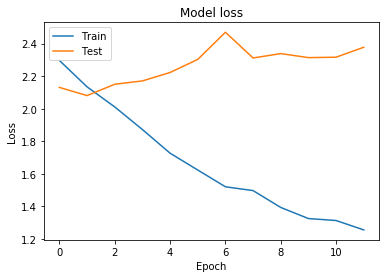

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [18]:
import gc
# del train_gen
# del valid_gen
# del X_train
# del y_train
# del train_df
gc.collect()


3561

In [19]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [20]:
def load_test(ts_length = 150000):
    base_dir = DATA/'test'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir/f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [21]:
test_data, test_ids = load_test()

In [22]:
X_test = ((test_data - X_train_mean)/ X_train_std)
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [23]:
y_pred = model.predict(X_test)

In [24]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [25]:
submission_df.to_csv("submission.csv", index=False)